# Load Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from transformers import pipeline
import hdbscan
import umap
import random

c:\Users\natha\Dropbox\Projects\Zoo_Feedback_2024\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('Survey_2024_Cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Start_Date'] = pd.to_datetime(df['Start_Date'])
df['End_Date'] = pd.to_datetime(df['End_Date'])
df.set_index('ID', inplace=True)

random.seed(123)
np.random.seed(123)

# Topic Modeling

In [50]:
# Aggregate and Clean Feedback
OPEN_TEXT_COLS = {
    "barrier": "Barrier_Feedback",
    "conservation": "Program_Feedback",
    "other": "Other_Feedback",
}

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"http\S+", "", s)
    return s


TRIVIAL = {"no", "no.", "none", 'none.', "n/a", 'n/a.', "na", 'n/a.', "nothing", "nothing.", "nil", "nil.", "nope",
           "nope.", "nope!", "nan", "nan.", "nothing at all", "nothing at all.", "no comments", "no comments.", "no comment", "no comment.", "nothin", "nothin.", "nah", "nah."}

rows = []
for source, col in OPEN_TEXT_COLS.items():
    if col not in df.columns:
        continue
    tmp = df[[col]].dropna().copy()
    tmp = tmp.rename(columns={col: "text"})
    tmp["source"] = source
    tmp["text"] = tmp["text"].astype(str).map(clean_text)
    tmp = tmp[tmp["text"].str.len() > 0]
    tmp_norm = tmp["text"].str.lower().str.strip()
    tmp = tmp[~tmp_norm.isin(TRIVIAL)]
    tmp["ID"] = tmp.index
    rows.append(tmp)

feedback_df = pd.concat(rows, ignore_index=True)
docs = feedback_df["text"].tolist()

In [51]:
# Specify embeddings for reproducibiltiy 
embedder = SentenceTransformer("all-mpnet-base-v2")
embeddings = embedder.encode(docs, show_progress_bar=True, normalize_embeddings=True)

Batches: 100%|██████████| 239/239 [03:00<00:00,  1.33it/s]


In [52]:
# Add Vectorizer to clean up after topic extraction and to use ngrams
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),  
    min_df=5
)

In [53]:
# Fit BERTopic model
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=25,
    min_samples=5,
    prediction_data=True
)

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=123  
)


topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs, embeddings)
feedback_df["topic_id"] = topics

topic_info = topic_model.get_topic_info()

2026-01-21 20:32:14,503 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-21 20:32:31,724 - BERTopic - Dimensionality - Completed ✓
2026-01-21 20:32:31,726 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-21 20:32:34,078 - BERTopic - Cluster - Completed ✓
2026-01-21 20:32:34,091 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-21 20:32:34,557 - BERTopic - Representation - Completed ✓


In [54]:
# Sentiment analysis pipeline
sent_pipe = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    return_all_scores=True,
    truncation=True,
    max_length=512
)
scores = sent_pipe(docs, batch_size=32)

label_to_val = {"negative": -1.0, "neutral": 0.0, "positive": 1.0}

def expected_sentiment(dist):
    return sum(label_to_val[d["label"]] * d["score"] for d in dist)

feedback_df["sent_score"] = [expected_sentiment(d) for d in scores]
feedback_df["sent_label"] = [
    max(d, key=lambda x: x["score"])["label"] for d in scores
]


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [55]:
inlier = feedback_df[feedback_df["topic_id"] != -1].copy()

topic_kpis = (
    inlier.groupby("topic_id")
    .agg(
        n=("text", "size"),
        avg_sent=("sent_score", "mean"),
        neg_share=("sent_label", lambda s: (s.str.lower() == "negative").mean()),
        pos_share=("sent_label", lambda s: (s.str.lower() == "positive").mean()),
    )
    .reset_index()
)

topic_kpis = topic_kpis.merge(
    topic_info[["Topic", "Name", "Count", "Representative_Docs"]].rename(columns={"Topic": "topic_id", "Count": "topic_count"}),
    on="topic_id",
    how="left"
).drop(columns=["n"])

topic_by_source = (
    inlier.groupby(["topic_id", "source"]).size().reset_index(name="count")
)
topic_by_source["share_within_topic"] = (
    topic_by_source.groupby("topic_id")["count"].transform(lambda s: s / s.sum())
)

topic_source_wide = (
    topic_by_source.pivot(index="topic_id", columns="source", values="share_within_topic")
    .fillna(0.0)
    .rename(columns=lambda c: f"share_{c}")
    .reset_index()
)

topic_kpis = topic_kpis.merge(topic_source_wide, on="topic_id", how="left")




In [56]:
topic_kpis[(topic_kpis['share_conservation'] < 0.5) & (topic_kpis['avg_sent'] < 0)].to_csv('Key_Complaints_2.csv', index=False)

In [57]:
Themes = {

    "mobility_accessibility": [
        13,  # Canadian Domain hill / steep terrain
        34,  # strollers, narrow paths, doors
        52,  # wheelchairs, pushing difficulty
        67,   # automatic doors, accessibility buttons
        53  # Canadian domain accessibility
    ],

    "navigation_info": [
        5,   # signage, signs, map, exits
        47   # website exhibit list / info
    ],

    "animal_visibility_availability": [
        16,  # animals visible / not visible
        22,  # animal displays / exhibits
        46,  # animals on display / exhibits
        50,  # disappointing animal sightings
        51,  # species-specific (eagles, etc.)
        59,  # animals not seen
        70,  # gorilla pavilion
        47   # exhibit information lacking
    ],

    "construction_closures_disruption": [
        1,   # construction boardwalk
        21,  # zoo construction ongoing
        27,  # African pavilion construction
        30,  # exhibits closed due to construction
        43,   # animals unavailable because of construction
        39  # splash pad
    ],

    "amenities_comfort": [
        0,   # washrooms / bathrooms
        12,  # water refill stations
        14,  # restaurants closed
        29,  # food options (burgers, fries)
        38,  # limited or expensive food options
        57,  # washrooms near attractions
        62   # food quality (pizza, service)
    ],

    "cost_value_pricing": [
        23,  # admission cost expensive
        31   # ticket pricing / value
    ],

    "operational_reliability": [
        2,   # zoomobile wait times
        3,   # zoomobile reliability / breakdowns
        11,  # parking QR code / payment issues
        63,  # cash vs card payment problems
        64   # zoomobile speaker / guide issues
    ]
}

In [58]:
topic_ids = topic_info.loc[topic_info["Topic"] != -1, "Topic"].tolist()

probs_df = pd.DataFrame(probs, columns=topic_ids, index=feedback_df.index)

for theme, tlist in Themes.items():
    probs_df[f"theme_{theme}_score"] = probs_df[tlist].max(axis=1)
    probs_df[f"theme_{theme}_flag"]  = (probs_df[f"theme_{theme}_score"] >= 0.05).astype(int)

for theme in Themes:
    feedback_df[f"theme_{theme}_score"] = probs_df[f"theme_{theme}_score"].values
    feedback_df[f"theme_{theme}_flag"]  = probs_df[f"theme_{theme}_flag"].values


In [59]:
theme_flag_cols = [f"theme_{t}_flag" for t in Themes]

respondent_theme = (
    feedback_df.groupby("ID")[theme_flag_cols]
    .max()
    .reset_index()
)

df = df.merge(respondent_theme, on="ID", how="left")
df[theme_flag_cols] = df[theme_flag_cols].fillna(0).astype(int)

df["left_any_comment"] = df["ID"].isin(feedback_df["ID"]).astype(int)

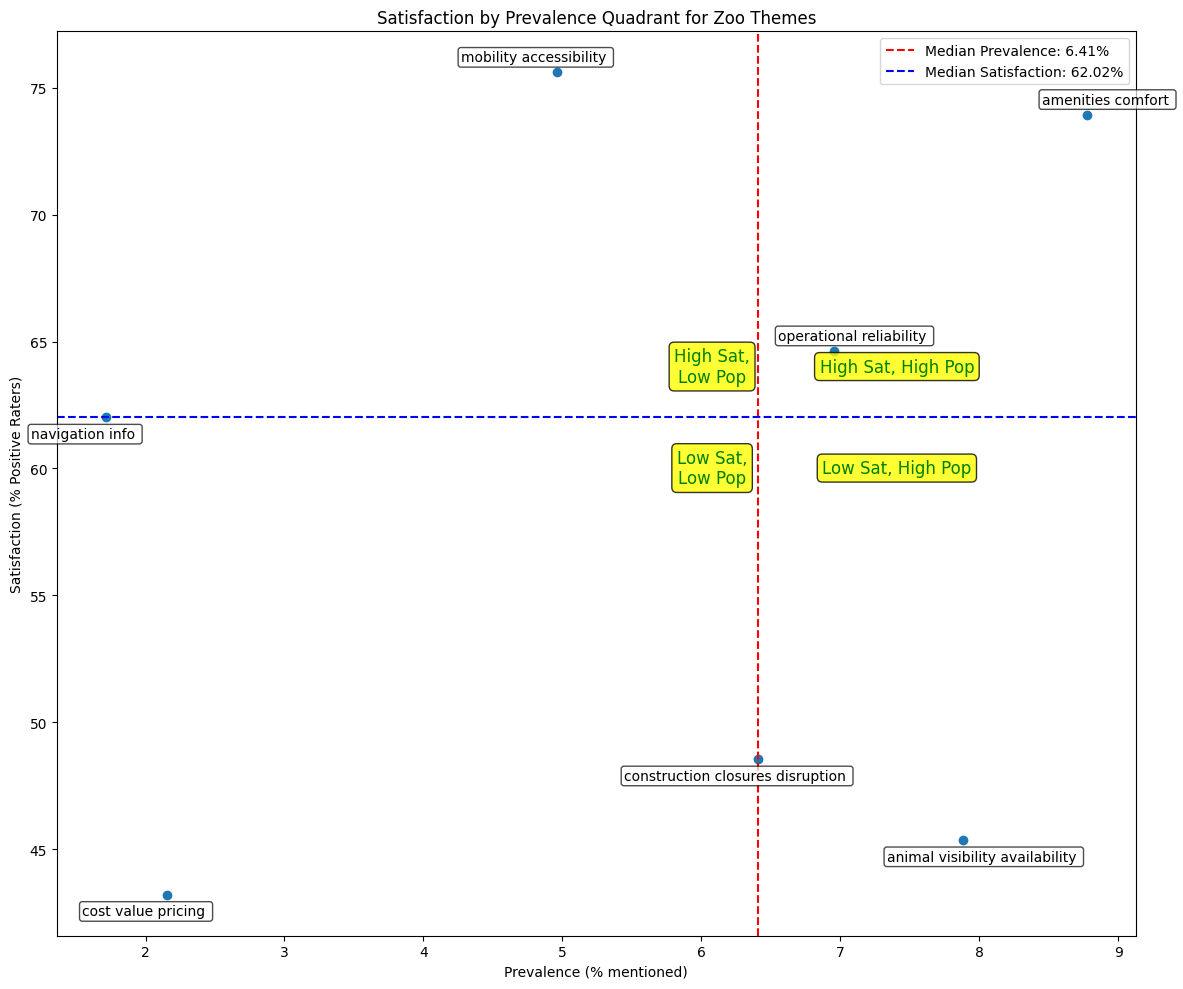

In [60]:
theme_cols = [col for col in df.columns if col.startswith('theme_')]

data = []
for col in theme_cols:
    theme = col.replace('theme_', '').replace('_', ' ').replace('flag','')
    prevalence = df[col].sum()/df.shape[0] * 100
    sat = (df[df[col] == 1]['Overall_Sat'].dropna() > 3).mean() * 100
    data.append({'Theme': theme, 'Prevalence': prevalence, 'Satisfaction': sat})

quad_df = pd.DataFrame(data)
median_pop, median_sat = quad_df['Prevalence'].median(), quad_df['Satisfaction'].median()
# Plot
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(quad_df['Prevalence'], quad_df['Satisfaction'])

# Add labels with adjusted positions
for i, row in quad_df.iterrows():
    x, y = row['Prevalence'], row['Satisfaction']
    if x > median_pop and y > median_sat:
        xytext = (15, 8)
    elif x > median_pop and y <= median_sat:
        xytext = (15, -15)
    elif x <= median_pop and y > median_sat:
        xytext = (-15, 8)
    else:
        xytext = (-15, -15)
    ax.annotate(row['Theme'], (x, y), xytext=xytext, textcoords='offset points', ha='center', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))

ax.set_xlabel('Prevalence (% mentioned)')
ax.set_ylabel('Satisfaction (% Positive Raters)')
ax.set_title('Satisfaction by Prevalence Quadrant for Zoo Themes')

# Add quadrant lines at medians
ax.axvline(median_pop, color='red', linestyle='--', label=f'Median Prevalence: {median_pop:.2f}%')
ax.axhline(median_sat, color='blue', linestyle='--', label=f'Median Satisfaction: {median_sat:.2f}%')

# Label quadrants centered in each quadrant
ax.text(median_pop + 1, median_sat + 2, 'High Sat, High Pop', ha='center', va='center', fontsize=12, color='green',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8))
ax.text(median_pop - .33, median_sat + 2, 'High Sat,\nLow Pop', ha='center', va='center', fontsize=12, color='green',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8))
ax.text(median_pop + 1, median_sat - 2, 'Low Sat, High Pop', ha='center', va='center', fontsize=12, color='green',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8))
ax.text(median_pop - .33, median_sat - 2, 'Low Sat,\nLow Pop', ha='center', va='center', fontsize=12, color='green',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8))

ax.legend()
plt.tight_layout()
plt.show()